## Setting

### Optional

In [3]:
!pip install xgboost lightgbm catboost -U

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root = "/content/drive/MyDrive/Machine Learning/"
import sys
sys.path.append(root)

### Required

In [6]:
from open.train_tuning import Model, LogisticRegression
from open.evaluation import show_confusion_matrix, show_roc_curve, show_pr_curve, show_prediction_score

is_binary = True

In [7]:
model_type = "stacked_all"
base_models = [
    "cat-{'learning_rate'_ 0.1, 'max_depth'_ 10, 'n_estimators'_ 200, 'subsample'_ 1.0}.pkl",
    "lgb-{'colsample_bytree'_ 1.0, 'learning_rate'_ 0.1, 'max_depth'_ 10, 'n_estimators'_ 200, 'subsample'_ 1.0}.pkl",
    "rf-{'max_depth'_ None, 'max_samples'_ None, 'n_estimators'_ 400}.pkl",
    "xgb-{'learning_rate'_ 0.5, 'max_depth'_ 10}.pkl",
    "logit-{'C'_ 1, 'penalty'_ 'l2'}.pkl",
    "svm-{'C'_ 10, 'gamma'_ 0.1, 'kernel'_ 'rbf'}.pkl"
]

## Loading Data

In [8]:
import pickle
import pandas as pd
import numpy as np

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/open_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y_binary"]
    y_train = np.where(y_train == -1, 0, y_train)

with open(f"{root}data/preprocess_data_33/open_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y_binary"]
    y_val = np.where(y_val == -1, 0, y_val)

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 20300
Validation data size:	 4350


In [9]:
X_train.columns

Index(['mean_iat', 'std_iat', 'median_iat', 'q25_iat', 'q75_iat', 'ratio_out',
       'switch_count', 'duration', 'n_packets', 'burst_count', 'burst_mean',
       'burst_std', 'burst_max', 'burst_ratio_in', 'num_in', 'num_out',
       'frac_in', 'in_first30', 'out_first30', 'mean_iat_first30',
       'std_iat_first30', 'median_iat_first30', 'q25_iat_first30',
       'q75_iat_first30', 'ratio_out_first30', 'switch_count_first30',
       'duration_first30', 'burst_count_first30', 'burst_mean_first30',
       'burst_std_first30', 'burst_max_first30', 'burst_ratio_in_first30',
       'frac_in_first30'],
      dtype='object')

## Model

### Model Loading

상관관계 matrix

In [10]:
preds= {}
model = Model(is_binary=is_binary)

for model_pkl in base_models:
  model.load_model(f"{root}open/models/{model_pkl}")
  model_nm = model_pkl.split("-")[0]

  preds[model_nm] = model._model.predict_proba(X_val)[:, 1]

pred_df = pd.DataFrame(preds)

corr_matrix = pred_df.corr()

print(corr_matrix)


            cat       lgb        rf       xgb     logit       svm
cat    1.000000 -0.122663 -0.136122 -0.114869 -0.204726 -0.115314
lgb   -0.122663  1.000000  0.963933  0.961859  0.776603  0.925434
rf    -0.136122  0.963933  1.000000  0.942331  0.790673  0.928496
xgb   -0.114869  0.961859  0.942331  1.000000  0.732894  0.910367
logit -0.204726  0.776603  0.790673  0.732894  1.000000  0.760044
svm   -0.115314  0.925434  0.928496  0.910367  0.760044  1.000000


사용할 조합 선택 (사용하지 않을 모델은 주석 처리)

In [11]:
base_models = [
    "cat-{'learning_rate'_ 0.1, 'max_depth'_ 10, 'n_estimators'_ 200, 'subsample'_ 1.0}.pkl",
    #"lgb-{'colsample_bytree'_ 1.0, 'learning_rate'_ 0.1, 'max_depth'_ 10, 'n_estimators'_ 200, 'subsample'_ 1.0}.pkl",
    #"rf-{'max_depth'_ None, 'max_samples'_ None, 'n_estimators'_ 400}.pkl",
    "xgb-{'learning_rate'_ 0.5, 'max_depth'_ 10}.pkl",
    #"logit-{'C'_ 1, 'penalty'_ 'l2'}.pkl",
    "svm-{'C'_ 10, 'gamma'_ 0.1, 'kernel'_ 'rbf'}.pkl"
]

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

model = Model(is_binary=is_binary)
# base model
estimators = []
print("[Load base models]")
for model_pkl in base_models:
  model.load_model(f"{root}open/models/{model_pkl}")
  model_nm = model_pkl.split("-")[0]
  try:
    features = model._model.feature_names_in_
  except:
    features = model._model.feature_names_
  print(f"- {model_nm}: {len(features)} features")
  transformer = ColumnTransformer([
      ('selector', 'passthrough', features)
  ])
  pipeline = Pipeline([
    ('preprocessor', transformer),
    ('classifier', model._model)
  ])
  estimators.append((model_nm, pipeline))
# meta model
print("\n[Load meta model]")
meta_model = LogisticRegression()

[Load base models]
- cat: 33 features
- xgb: 33 features
- svm: 33 features

[Load meta model]


In [13]:
estimators

[('cat',
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('selector', 'passthrough',
                                                    ['burst_max_first30',
                                                     'burst_count', 'ratio_out',
                                                     'num_in', 'duration',
                                                     'burst_std_first30',
                                                     'burst_count_first30',
                                                     'out_first30',
                                                     'burst_ratio_in',
                                                     'burst_mean', 'frac_in',
                                                     'burst_ratio_in_first30',
                                                     'n_packets', 'std_iat',
                                                     'burst_mean_first30',
                                                 

### Stacking

In [14]:
from sklearn.ensemble import StackingClassifier

stacked_model = StackingClassifier(estimators=estimators, final_estimator=meta_model)
stacked_model.fit(X_train, y_train)

0:	learn: 0.6106246	total: 137ms	remaining: 27.2s
1:	learn: 0.5473159	total: 219ms	remaining: 21.7s
2:	learn: 0.4970238	total: 302ms	remaining: 19.9s
3:	learn: 0.4561926	total: 386ms	remaining: 18.9s
4:	learn: 0.4236074	total: 470ms	remaining: 18.3s
5:	learn: 0.4009892	total: 569ms	remaining: 18.4s
6:	learn: 0.3782962	total: 659ms	remaining: 18.2s
7:	learn: 0.3637102	total: 739ms	remaining: 17.7s
8:	learn: 0.3510889	total: 818ms	remaining: 17.4s
9:	learn: 0.3370557	total: 901ms	remaining: 17.1s
10:	learn: 0.3251424	total: 982ms	remaining: 16.9s
11:	learn: 0.3146797	total: 1.06s	remaining: 16.6s
12:	learn: 0.3072515	total: 1.14s	remaining: 16.4s
13:	learn: 0.3017037	total: 1.23s	remaining: 16.3s
14:	learn: 0.2933939	total: 1.31s	remaining: 16.2s
15:	learn: 0.2878018	total: 1.4s	remaining: 16.1s
16:	learn: 0.2841005	total: 1.48s	remaining: 15.9s
17:	learn: 0.2792991	total: 1.55s	remaining: 15.7s
18:	learn: 0.2739310	total: 1.66s	remaining: 15.8s
19:	learn: 0.2697933	total: 1.74s	remainin

StackingClassifier(estimators=[('cat',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('selector',
                                                                                  'passthrough',
                                                                                  ['burst_max_first30',
                                                                                   'burst_count',
                                                                                   'ratio_out',
                                                                                   'num_in',
                                                                                   'duration',
                                                                                   'burst_std_first30',
                                                                                   'burst_count_first30',
                                                                                   'out_first30',
                                                                                   'burst_ratio_in',
                                                                                   'burst_mean',
                                                                                   'frac_in',
                                                                                   'burst_ratio_in_first30',
                                                                                   'n_packets',
                                                                                   'std_iat',
                                                                                   'burst_mean_...
       'median_iat_first30', 'q25_iat_first30', 'q75_iat_first30',
       'ratio_out_first30', 'switch_count_first30', 'duration_first30',
       'burst_count_first30', 'burst_mean_first30', 'burst_std_first30',
       'burst_max_first30', 'burst_ratio_in_first30', 'frac_in_first30'],
      dtype=object))])),
                                                ('classifier',
                                                 SVC(C=10, gamma=0.1,
                                                     probability=True))]))],
                   final_estimator=LogisticRegression())

### Evaluation

In [22]:
y = y_val
y_pred = stacked_model.predict(X_val)
y_prob = stacked_model.predict_proba(X_val)[:, 1]

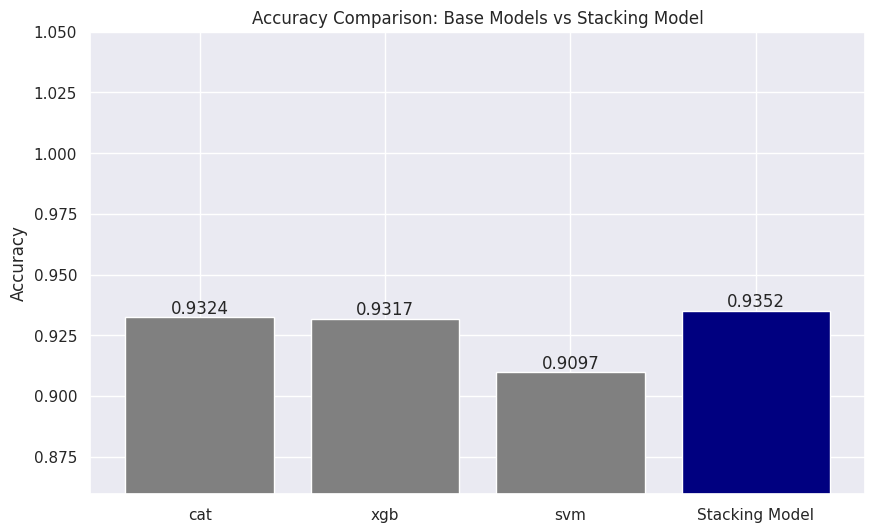

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

model_scores = {}

# 1. Base Model들의 Accuracy 계산
for name, model in zip(stacked_model.named_estimators_.keys(), stacked_model.estimators_):
    base_y_pred = model.predict(X_val)
    model_scores[name] = accuracy_score(y, base_y_pred)
# 2. Stacking Model의 Accuracy 계산
model_scores['Stacking Model'] = accuracy_score(y, y_pred)


plt.figure(figsize=(10, 6))

names = list(model_scores.keys())
values = list(model_scores.values())
colors = ['gray'] * (len(names) - 1) + ['navy']
bars = plt.bar(names, values, color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.title('Accuracy Comparison: Base Models vs Stacking Model')
plt.ylabel('Accuracy')
plt.ylim(min(values) - 0.05, 1.05)
plt.show()

1. Confusion Matrix

              precision    recall  f1-score   support

 unmonitored       0.92      0.89      0.90      1500
   monitored       0.94      0.96      0.95      2850

    accuracy                           0.94      4350
   macro avg       0.93      0.92      0.93      4350
weighted avg       0.93      0.94      0.93      4350



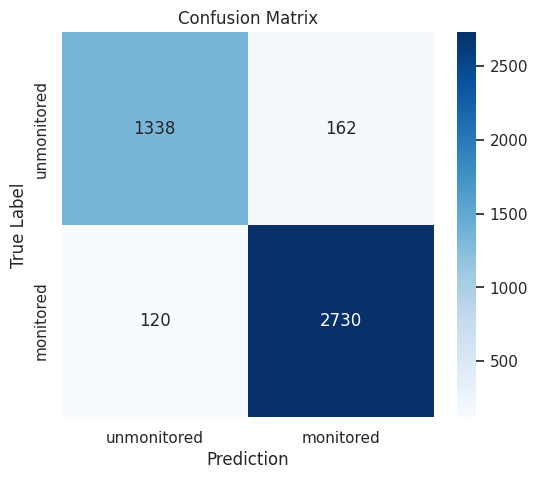

In [24]:
show_confusion_matrix(y, y_pred, model_type)

2. ROC Curve

- ROC AUC Score: 0.9826


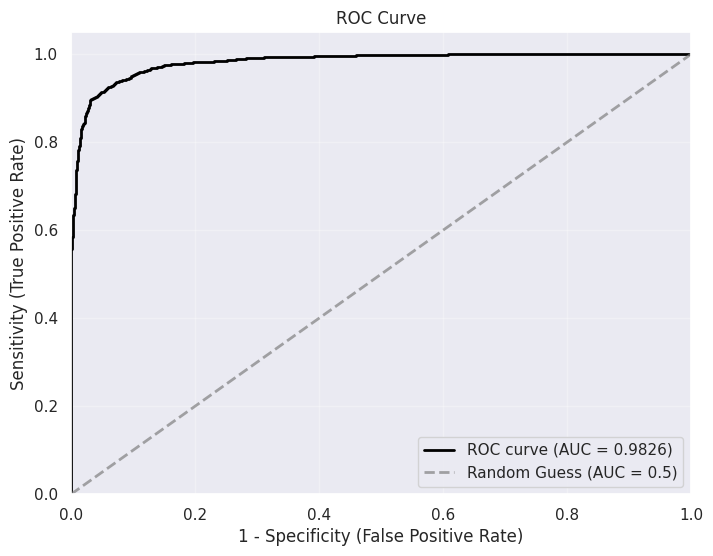

In [25]:
show_roc_curve(y, y_prob, model_type)

3. PR Curve

- Average Precision (AP) Score: 0.9908


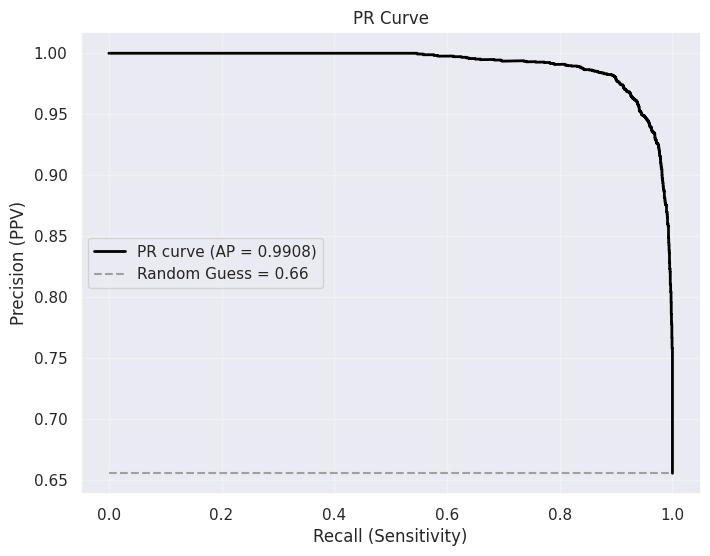

In [26]:
show_pr_curve(y, y_prob, model_type)

4. Prediction Score


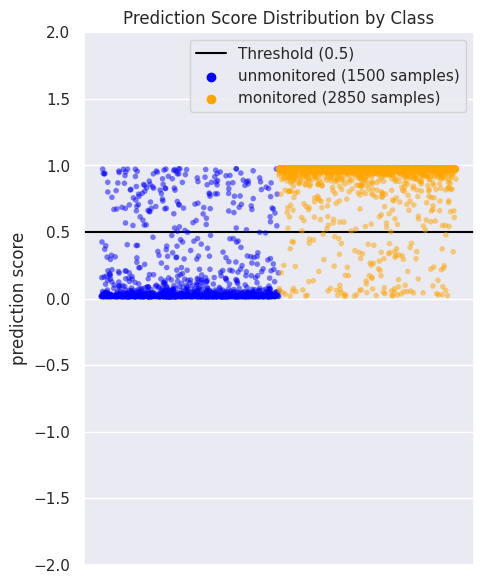

In [20]:
show_prediction_score(y, y_prob, model_type)

### Save Model

In [21]:
import joblib

joblib.dump(stacked_model, f"{root}/open/models/{model_type}")

['/content/drive/MyDrive/Machine Learning//open/models/stacked_all']